# Step 3-2 ARIMAX

For ARIMA-X, the features we should add are exogenous variables.

* ARIMAX is trained on train data of original values of selected features from the feature selection step

* ARIMAX already handles temporal dynamics, exclude `time lags`

The selected features are:

`gdp`, `primary_energy_consumption`, `population`, `biofuel_share`, `low_carbon_share`, `methane`, `nitrous_oxide`

**workflow of ARIMAX**:

select exogenous variables -> check stationarity of exogenous variables -> Skip stationary part

Run AutoARIMAX:

train ARIMAX on train data -> fit once -> forecast test period

### Necessary imports

In [56]:
# Necessary imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import warnings
import os

warnings.filterwarnings("ignore")

### Config

In [57]:
TARGET_VARIABLES = 'co2'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
G7_COUNTRIES = ['United States', 'China', 'India', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
TEST_SIZE = 9
save_dir = 'data/03_02_results'
os.makedirs(save_dir, exist_ok=True)

# ARIMA optimal orders
ARIMA_ORDERS = {
    'United States': (0, 1, 0),
    'China': (0, 2, 0),
    'India': (1, 1, 1)
}

# Exogenous variables
EXOG_VARIABLES = [
    'gdp',
    'primary_energy_consumption',
    'population',
    'biofuel_share_energy', 
    'low_carbon_share_energy',
    'methane',
    'nitrous_oxide'
]

### Data load

In [58]:
def load_data(save_dir='data'):
    data_files = {
        'lag_df': os.path.join(save_dir, 'lag_df.csv'),
        'g7_lag_df': os.path.join(save_dir, 'g7_lag_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv'),
        'three_interpolated_df': os.path.join(save_dir, 'three_interpolated_df.csv'),
        'g7_interpolated_df': os.path.join(save_dir, 'g7_interpolated_df.csv'),
        'g20_interpolated_df': os.path.join(save_dir, 'g20_interpolated_df.csv'),
        'all_interpolated_df': os.path.join(save_dir, 'all_interpolated_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [59]:
data = load_data()

lag_df = data['lag_df']
lag_1969_df = lag_df[lag_df['year'] >= 1969].copy()
lag_1969_df = lag_1969_df[lag_1969_df['year'] < 2023]

g7_lag_df = data['g7_lag_df']
g7_lag_1969_df = g7_lag_df[g7_lag_df['year'] >= 1969].copy()
g7_lag_1969_df = g7_lag_1969_df[g7_lag_1969_df['year'] < 2023]

g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]

lag_three_sel_1969_df = data['lag_three_sel_1969_df']

three_interpolated_df = data['three_interpolated_df']
g7_interpolated_df = data['g7_interpolated_df']
g20_interpolated_df = data['g20_interpolated_df']
all_interpolated_df = data['all_interpolated_df']

Loaded lag_df: (55529, 992)
Loaded g7_lag_df: (1890, 992)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)
Loaded three_interpolated_df: (135, 992)
Loaded g7_interpolated_df: (405, 992)
Loaded g20_interpolated_df: (855, 992)
Loaded all_interpolated_df: (9090, 992)


In [60]:
# Checking if exogenous varialbes in the dataset
for feature in EXOG_VARIABLES:
    if feature in three_interpolated_df.columns:
        print(f"    {feature} in the dataset")
    else:
        print(f"    {feature} not in the dataset")

    gdp in the dataset
    primary_energy_consumption in the dataset
    population in the dataset
    biofuel_share_energy in the dataset
    low_carbon_share_energy in the dataset
    methane in the dataset
    nitrous_oxide in the dataset


### Data preparation

In [61]:
# train_test_split
def tts_ARIMAX_by_year(interpolated_df, full_df, countries, test_size=TEST_SIZE, target_var=TARGET_VARIABLES, exog_vars=EXOG_VARIABLES):
    train_data = {}
    test_data = {}

    for country in countries:
        country_train = interpolated_df[interpolated_df['country'] == country].sort_values('year').copy()

        country_full = full_df[full_df['country'] == country].sort_values('year').copy()
        split_idx = len(country_full) - test_size
        country_test = country_full.iloc[split_idx:].copy()

        train_data[country] = {
            'y': country_train[target_var].values,
            'X': country_train[exog_vars].values,
            'years': country_train['year'].values
        }

        test_data[country] = {
            'y': country_test[target_var].values,
            'X': country_test[exog_vars].values,
            'years': country_test['year'].values
        }

        print(f"\n{country}:")
        print(f"    Train: {len(train_data[country]['y'])} samples, years {train_data[country]['years'][0]}-{train_data[country]['years'][-1]}")
        print(f"    Test:  {len(test_data[country]['y'])} samples, years {test_data[country]['years'][0]}-{test_data[country]['years'][-1]}")
    
    return train_data, test_data

In [62]:
# Three countries
three_train_data, three_test_data = tts_ARIMAX_by_year(
    three_interpolated_df,
    lag_three_sel_1969_df,
    SELECTED_COUNTRIES
)


United States:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

China:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

India:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022


### Helper

In [63]:
def mase(y_actual, y_pred, y_train):
    mae = np.mean(np.abs(y_actual - y_pred))
    
    naive_errors = np.abs(np.diff(y_train))
    mae_naive = np.mean(naive_errors)

    if mae_naive == 0:
        return np.nan
    
    mase = mae / mae_naive

    return mase

In [64]:
def adf_test(series, name='Series', country=''):
    """
    p_value < 0.05: Rejct Null hypothesis -> stationary
    """
    # pd -> dropna
    if isinstance(series, pd.Series):
        updated_series = series.dropna()
    # np -> remove nan
    else:
        updated_series = series[~np.isnan(series)]

    result = adfuller(updated_series, autolag='AIC')

    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f"\n{name} ({country}):")
    print(f"ADF Statistics: {adf_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        is_stationary = True
    else:
        is_stationary = False

    print(f"Critical Value:")
    for k, v in critical_values.items():
        print(f"    {k}: {v:.4f}")

    return {
        'adf_stat': adf_stat,
        'p_value': p_value,
        'critical_values': critical_values,
        'is_stationary': is_stationary
    }

In [65]:
def check_stationarity(df, features, country):
    print(f"\nFor {country.upper()}")

    results = {}

    for feature in features:
        feature_data = df[feature].values
        result = adf_test(feature_data, name=feature, country=country)
        results[feature] = result

    return results

In [66]:
def difference_series(series, order):
    diff_series = series.copy()
    for i in range(order):
        diff_series = diff_series.diff().dropna()
    return diff_series

### Check Stationarity for each country

In [67]:
stationarity_results = {}

for country in SELECTED_COUNTRIES:
    country_train = three_interpolated_df[three_interpolated_df['country'] == country].sort_values('year')

    print(f"\nOriginal features for {country.upper()}")
    original_results = check_stationarity(country_train, EXOG_VARIABLES, country)

    d = ARIMA_ORDERS[country][1]

    if d > 0:
        differenced_results = {}
        for feature in EXOG_VARIABLES:
            feature_data = country_train[feature].values

            diff_data = feature_data.copy()
            for i in range(d):
                diff_data = np.diff(diff_data)

            result = adf_test(diff_data, name=f"{feature} d={d}", country=country)
            differenced_results[feature] = result

        stationarity_results[country] = {
            'original': original_results,
            'differenced': differenced_results,
            'd': d
        }
    else:
        stationarity_results[country] = {
            'original': original_results,
            'd': d
        }


Original features for UNITED STATES

For UNITED STATES

gdp (United States):
ADF Statistics: 0.3374
p-value: 0.9790
Critical Value:
    1%: -3.5925
    5%: -2.9315
    10%: -2.6041

primary_energy_consumption (United States):
ADF Statistics: -1.6422
p-value: 0.4611
Critical Value:
    1%: -3.5886
    5%: -2.9299
    10%: -2.6032

population (United States):
ADF Statistics: 5.3776
p-value: 1.0000
Critical Value:
    1%: -3.5966
    5%: -2.9333
    10%: -2.6050

biofuel_share_energy (United States):
ADF Statistics: 2.0162
p-value: 0.9987
Critical Value:
    1%: -3.6056
    5%: -2.9371
    10%: -2.6070

low_carbon_share_energy (United States):
ADF Statistics: -1.3009
p-value: 0.6287
Critical Value:
    1%: -3.5886
    5%: -2.9299
    10%: -2.6032

methane (United States):
ADF Statistics: 0.5040
p-value: 0.9850
Critical Value:
    1%: -3.5886
    5%: -2.9299
    10%: -2.6032

nitrous_oxide (United States):
ADF Statistics: -1.4219
p-value: 0.5717
Critical Value:
    1%: -3.5886
    5%: -2.

In [68]:
for country in SELECTED_COUNTRIES:
    d = stationarity_results[country]['d']
    print(f"\n{country.upper()} - ARIMA order{ARIMA_ORDERS[country]}")

    if d > 0:
        print(f"\nBefore differencing:")
        for feature, result in stationarity_results[country]['original'].items():
            stat = "Stationary" if result['is_stationary'] else "Not Stationary"
            print(f"    {feature}: {stat}, p-value = {result['p_value']:.4f}")

        print(f"\nDifferenced features d = {d}:")
        for feature, result in stationarity_results[country]['differenced'].items():
            stat = "Stationary" if result['is_stationary'] else "Not Stationary"
            print(f"    {feature}: {stat}, p-value = {result['p_value']:.4f}")
    else:
        print(f" No differencing needed:")
        for feature, result in stationarity_results[country]['original'].items():
            stat = "Stationary" if result['is_stationary'] else "Not Stationary"
            print(f"    {feature}: {stat}, p-value = {result['p_value']:.4f}")


UNITED STATES - ARIMA order(0, 1, 0)

Before differencing:
    gdp: Not Stationary, p-value = 0.9790
    primary_energy_consumption: Not Stationary, p-value = 0.4611
    population: Not Stationary, p-value = 1.0000
    biofuel_share_energy: Not Stationary, p-value = 0.9987
    low_carbon_share_energy: Not Stationary, p-value = 0.6287
    methane: Not Stationary, p-value = 0.9850
    nitrous_oxide: Not Stationary, p-value = 0.5717

Differenced features d = 1:
    gdp: Stationary, p-value = 0.0002
    primary_energy_consumption: Stationary, p-value = 0.0000
    population: Not Stationary, p-value = 0.8125
    biofuel_share_energy: Not Stationary, p-value = 0.5650
    low_carbon_share_energy: Stationary, p-value = 0.0000
    methane: Stationary, p-value = 0.0000
    nitrous_oxide: Stationary, p-value = 0.0000

CHINA - ARIMA order(0, 2, 0)

Before differencing:
    gdp: Not Stationary, p-value = 1.0000
    primary_energy_consumption: Not Stationary, p-value = 0.9982
    population: Statio

Only `methane` and `nitrous oxide` were stationary after differencing for all the countries. Only they are available for manual ARIMAX for three coutnries. It is better to run autoARIMAX

### Auto ARIMAX

In [69]:
def train_auto_ARIMAX(y_train, X_train):
    model = auto_arima(
        y_train,
        exogenous=X_train,
        start_p=0,
        start_q=0,
        max_p=5,
        max_q=5,
        max_d=2,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return model

In [70]:
three_arimax_models = {}
three_optimal_orders = {}

for country in SELECTED_COUNTRIES:
    print(f"\nAUTO ARIMAX for {country.upper()}")
    print(f"Training samples: {len(three_train_data[country]['y'])}")
    print(f"Number of exogenous variables: {len(EXOG_VARIABLES)}")
    
    # Train Auto ARIMAX model
    model = train_auto_ARIMAX(
        three_train_data[country]['y'],
        three_train_data[country]['X'],
    )
    
    three_arimax_models[country] = model
    three_optimal_orders[country] = model.order
    
    print(f"\n Optimal order for auto ARIMAX{model.order}")
    print(f"    AIC: {model.aic():.2f}")
    print(f"    BIC: {model.bic():.2f}")

print("\nOptimal order summary")
for country, order in three_optimal_orders.items():
    print(f"    {country}: ARIMA{order}")


AUTO ARIMAX for UNITED STATES
Training samples: 45
Number of exogenous variables: 7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=572.431, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=573.491, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=572.886, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=572.374, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=572.300, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=573.649, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=573.985, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=572.455, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=574.735, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=571.861, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=572.228, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=572.981, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0]        

### Forecast Test Period

In [71]:
def forecast_auto_ARIMAX(model, X_test, steps=TEST_SIZE):
    forecasts = model.predict(n_periods=steps, exogenous=X_test)
    return forecasts

In [72]:
three_forecasts = {}

for country in SELECTED_COUNTRIES:
    print(f"\nFor {country.upper()}")

    y_pred = forecast_auto_ARIMAX(
        three_arimax_models[country],
        three_test_data[country]['X']
    )

    three_forecasts[country] = y_pred
    print(f"Forecast range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    print(f"Actual range: [{three_test_data[country]['y'].min():.2f}, {three_test_data[country]['y'].max():.2f}]")


For UNITED STATES
Forecast range: [5493.07, 5502.28]
Actual range: [4714.63, 5528.68]

For CHINA
Forecast range: [10335.87, 13734.48]
Actual range: [9762.71, 11447.91]

For INDIA
Forecast range: [2098.59, 3009.48]
Actual range: [2148.34, 2831.17]


### Model Evaluation

In [73]:
def evaluate_ARIAMX(y_actual, y_pred, y_train, country_name, order):
    rmse_score = np.sqrt(mean_squared_error(y_actual, y_pred))
    mase_score = mase(y_actual, y_pred, y_train)

    results = {
        'country': country_name,
        'order': str(order),
        'rmse_score': rmse_score,
        'mase_score': mase_score
    }
    
    return results

In [74]:
three_evaluation_results = []

for country in SELECTED_COUNTRIES:
    results = evaluate_ARIAMX(
        three_test_data[country]['y'],
        three_forecasts[country],
        three_train_data[country]['y'],
        country,
        three_optimal_orders[country]
    )

    three_evaluation_results.append(results)

    print(f"\n{country.upper()} - ARIMA{three_optimal_orders[country]}:")
    print(f"    RMSE: {results['rmse_score']:.4f}")
    print(f"    MASE: {results['mase_score']:.4f}")

results_df = pd.DataFrame(three_evaluation_results)
results_df = results_df.sort_values('rmse_score', ascending=True)


UNITED STATES - ARIMA(1, 1, 1):
    RMSE: 368.3954
    MASE: 2.2979

CHINA - ARIMA(0, 2, 2):
    RMSE: 1651.0601
    MASE: 6.9919

INDIA - ARIMA(0, 2, 1):
    RMSE: 151.7208
    MASE: 2.5784


### Visualisation

In [85]:
def plot_ARIMAX_results(train_data, test_data,  forecasts, countries, orders):
    fig, axes = plt.subplots(len(countries), 1, figsize=(12, 3*len(countries)))

    if len(countries) == 1:
        axes= [axes]

    for idx, country in enumerate(countries):
        ax = axes[idx]

        # Training data
        ax.plot(train_data[country]['years'], 
                train_data[country]['y'], 
                label='Historical', 
                color='blue', 
                linewidth=2)
        
        # Test data
        ax.plot(test_data[country]['years'], 
                test_data[country]['y'], 
                label='Actual Test', 
                color='blue', 
                linewidth=2,
                marker='o')
        
        # Forecasts
        ax.plot(test_data[country]['years'], 
                forecasts[country], 
                label='Auto ARIMAX Forecast', 
                color='red', 
                linewidth=2,
                linestyle='--',
                marker='s')
        
        ax.set_xlabel('Year', fontsize=11)
        ax.set_ylabel('CO2 Emissions', fontsize=11)
        ax.set_title(f'{country} - Auto ARIMA{orders[country]}', 
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')

    plt.tight_layout()

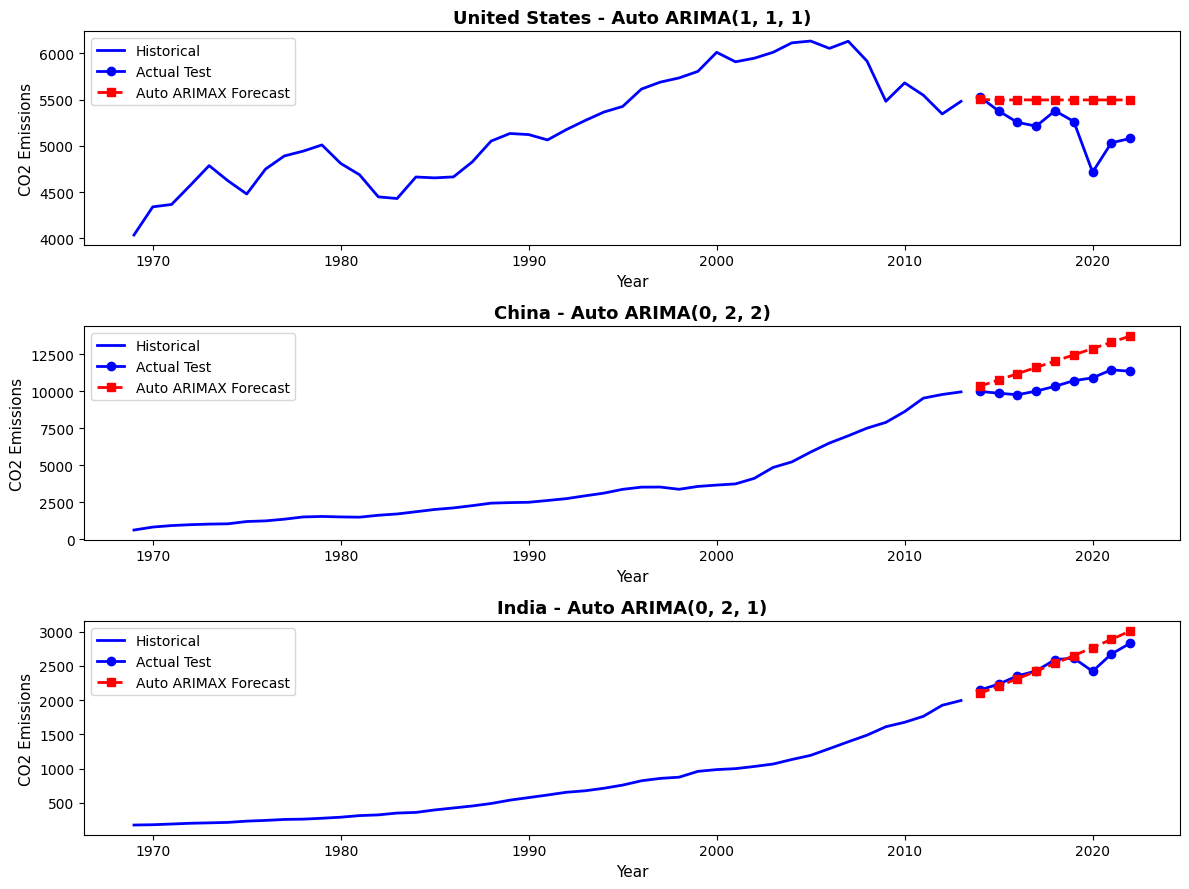

In [86]:
plot_ARIMAX_results(three_train_data, three_test_data, three_forecasts, SELECTED_COUNTRIES, three_optimal_orders)